In [2]:
import numpy as np
import torch.nn
import json
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches


from PIL import Image

# Set default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 40.0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Set image and label directory
imgs_dir = "../cityscapes_dataset/cityscapes_samples"
labels_dir = "../cityscapes_dataset/cityscapes_samples_labels"

# Set accepted labels for this project
label_dict = {
    "person": 1,
    "persongroup": 2,
    "rider": 3,
    "bicycle": 4,
    "bicyclegroup": 5,
    "car": 6,
    "cargroup": 7,
    "bus": 8,
    "truck": 9,
    "traffic sign": 10,
    "traffic light": 11
}

In [4]:
from vehicle_detection.cityscape_datalist import *

# Create a data list of images
cs_data_list = CityScapeDatalist(imgs_dir, labels_dir, label_dict)
cs_data_list.prepare_data_list()

# Split data into train test and validation
cs_data_list.split_data()

1000 images processed


In [5]:
# TODO: Plot sample images
cs_data_list.data_list[0]

{'bounding_boxes': array([[  17.,  410., 1887., 1010.],
        [  53.,  422.,  474.,  515.],
        [ 510.,  401.,  687.,  445.],
        [ 697.,  354.,  826.,  408.],
        [ 853.,  344.,  933.,  408.],
        [1000.,  352., 1095.,  421.],
        [1154.,  268., 1175.,  299.],
        [ 908.,  269., 1019.,  335.],
        [ 949.,   18., 1398.,  259.],
        [1437.,   13., 1747.,  369.],
        [1787.,   19., 2038.,  585.],
        [1159.,  422., 2035.,  916.],
        [1718.,   47., 1777.,  679.],
        [1603.,  255., 1684.,  537.],
        [1751.,  271., 1820.,  557.],
        [1280.,  422., 1397.,  467.],
        [  16.,   11.,  710.,  427.],
        [ 730.,   90.,  801.,  153.],
        [ 729.,    8.,  809.,   74.],
        [ 761.,  173.,  807.,  217.],
        [ 852.,    7.,  885.,   32.],
        [ 901.,    6.,  984.,   23.],
        [ 824.,  109.,  940.,  276.],
        [ 494.,  243.,  499.,  427.],
        [1157.,  403., 1160.,  435.],
        [ 725.,  149.,  805.,  2

In [13]:
from vehicle_detection.cityscape_dataset import *
from vehicle_detection.solver import *

# Create a dataset using the data list you prepared
input_dim=(300, 300)
train_dataset = CityScapeDataset(cs_data_list.train_list, input_dim=input_dim, mode="train")
valid_dataset = CityScapeDataset(cs_data_list.valid_list, input_dim=input_dim, mode="test")

# Create a solver to train the model
solver = Solver(train_dataset, valid_dataset, batch_size=64)

In [7]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from vehicle_detection.bbox_helper import generate_prior_bboxes, loc2bbox, center2corner

# Draw bounding boxes on a sample from the data loader
mean_img = np.asarray((127, 127, 127), dtype=np.float32).reshape(3, 1, 1)
std_img = 128.0

with torch.no_grad():
    # Now I'm going to read a few data examples from the DataLoader and plot them
    idx, (x, gt_locs, gt_labels) = next(enumerate(solver.train_loader))
    
    print("Image shape is of shape: {}".format(x.shape))
    print("bbox_tensor is of shape {}".format(gt_locs.shape))
    print("bbox_label_tensor is of shape: {}".format(gt_labels.shape))

    NUM_IMGS = 2
    fig, ax = plt.subplots(NUM_IMGS)
    img_sample = x[:NUM_IMGS].clone()
    loc_sample = gt_locs[:NUM_IMGS, :, :].clone()
    prior_bboxes = generate_prior_bboxes()
    for i in range(1, NUM_IMGS + 1):
        img = np.asarray(img_sample[i - 1])
        img = (img * std_img) + mean_img
        img = np.ascontiguousarray(img.transpose(1, 2, 0).astype('uint8'))
        # Convert the locations to bbox
        bbox = loc2bbox(loc_sample[i - 1], prior_bboxes)
        # Convert bbox to corner format
        bbox = center2corner(bbox)
        bbox[:,[0,2]] *= input_dim[0]
        bbox[:,[1,3]] *= input_dim[1]
        # Draw bounding boxes on the image
        for k, (x, y, xw, yh) in enumerate(bbox):
            if gt_labels[i-1][k] in range(1,12):
                rect = patches.Rectangle([x,y], xw-x, yh-y, linewidth=1, edgecolor='r',
                                         facecolor='none')
                ax[i-1].add_patch(rect)
        ax[i-1].imshow(img)
    plt.show()

Image shape is of shape: torch.Size([64, 3, 300, 300])
bbox_tensor is of shape torch.Size([64, 2982, 4])
bbox_label_tensor is of shape: torch.Size([64, 2982])


In [14]:
from vehicle_detection.ssd_net import *
from vehicle_detection.bbox_loss import *

# Instantiate the model
num_classes = len(set(label_dict.values())) + 1

ssd_net = SSD(num_classes).cuda()

# Create an optimizer
optimizer = torch.optim.Adam(ssd_net.parameters(), lr=1e-3)

# Initialize loss function
loss_function = MultiboxLoss()

train_bbox_losses = []
train_class_losses = []

In [15]:
# Load the model if it exists
net_state = torch.load('vehicle_detection/ssd_net')
ssd_net.load_state_dict(net_state)

In [16]:
# Training the model
lr = 1e-3
for num_epochs in [10, 20, 20, 15, 5]:
# for num_epochs in [1]:
    optimizer.param_groups[0]['lr'] = lr
    tclass_loss, tbbox_loss, vclass_loss, vbbox_loss = solver.train(ssd_net, 
                                                                    optimizer, 
                                                                    loss_function,
                                                                    num_epochs=num_epochs,
                                                                    print_every=200)
    
    train_class_losses += tclass_loss
    train_bbox_losses += tbbox_loss
    lr *= 1e-1

This is epoch 0


In [17]:
# Save the model
net_state = ssd_net.state_dict()
torch.save(net_state, 'vehicle_detection/ssd_net')

In [18]:
# Generate prior boxes
prior_bboxes = generate_prior_bboxes()
train_loader = solver.train_loader
valid_loader = solver.valid_loader

In [25]:
# Plot predictions of bounding boxes on a sample from validation dataset
solver = Solver(train_dataset, valid_dataset, batch_size=32)
accuracy, confidences, locs, vclass_loss, vbbox_loss = solver.evaluate_model(ssd_net, loss_function, loader=valid_loader)

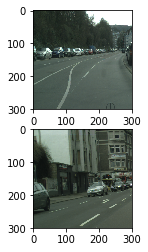

In [10]:
# Plotting sample bounding boxes
NUM_IMGS = 2
fig, ax = plt.subplots(NUM_IMGS)
mean_img = np.asarray((127, 127, 127), dtype=np.float32).reshape(3, 1, 1)
std_img = 128.0

with torch.no_grad():
    # Now I'm going to read a few data examples from the DataLoader and plot them
    idx, (x, _, _) = next(enumerate(solver.train_loader))

    img_sample = x[:NUM_IMGS].clone().cpu()
    loc_sample = locs[:NUM_IMGS, :, :].clone().cpu()
    conf_sample = confidences[:NUM_IMGS, :, :].clone().cpu()
    for i in range(1, NUM_IMGS + 1):
        img = np.asarray(img_sample[i - 1])
        img = (img * std_img) + mean_img
        img = np.ascontiguousarray(img.transpose(1, 2, 0).astype('uint8'))
        h, w, c = img.shape
        # Convert the locations to bbox
        bbox = loc2bbox(loc_sample[i - 1], prior_bboxes)
        # Convert bbox to corner format
        bbox = center2corner(bbox)
        bbox[:, [0, 2]] *= w
        bbox[:, [1, 3]] *= h
        # Apply nms on the bounding boxes
        sel_boxes = nms_bbox(bbox, conf_sample[i-1])
        # Draw bounding boxes on the image
        for (bbox, label) in sel_boxes:
            (x, y, xw, yh) = bbox
            rect = patches.Rectangle([x, y], xw - x, yh - y, linewidth=1, edgecolor='r',
                                     facecolor='none')
            ax[i - 1].add_patch(rect)
        ax[i - 1].imshow(img)
    plt.show()


In [ ]:
from vehicle_detection.util.module_util import *
summary_layers(ssd_net.base_net, input_size=(3, 300, 300))

In [49]:
a = torch.randn(2, 2, 2)
b = torch.randn(1, 2, 2)
print(a)
print(b)
print(torch.min(a, b))

tensor([[[-0.2884, -1.3171],
         [ 0.9776,  0.4853]],

        [[-1.3066,  1.0038],
         [ 1.4060, -0.9773]]])
tensor([[[ 1.8054, -0.0292],
         [-0.3860, -1.1643]]])
tensor([[[-0.2884, -1.3171],
         [-0.3860, -1.1643]],

        [[-1.3066, -0.0292],
         [-0.3860, -1.1643]]])


In [51]:
a = a.permute(1, 0 ,2).contiguous()
b = b.permute(1, 0, 2).contiguous()
print(a)
print(b)
print(torch.min(a, b))

tensor([[[-0.2884, -1.3171],
         [-1.3066,  1.0038]],

        [[ 0.9776,  0.4853],
         [ 1.4060, -0.9773]]])
tensor([[[ 1.8054, -0.0292]],

        [[-0.3860, -1.1643]]])
tensor([[[-0.2884, -1.3171],
         [-1.3066, -0.0292]],

        [[-0.3860, -1.1643],
         [-0.3860, -1.1643]]])
